# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 18 апреля 2018, 06:00 <br\>
**Штраф за опоздание:** -3 балла после 06:00 18 апреля, -6 баллов после 06:00 25 апреля, -9 баллов после 06:00 2 мая

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

%matplotlib inline
%load_ext pycodestyle_magic

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [3]:
USER_NAME = u"Сидоренко".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L1 регуляризацией с помощью метода  Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.

$$ \frac{\partial L}{\partial w_i} = - \frac{1}{N} \sum \limits_{j}^{} \left[ \left( 1 - \sigma\left( y^{(j)}g(x^{(j)})\right) \right) y^{(j)} x_i^{(j)} \right] + \frac{1}{C}sign(w_i) $$  $$ i > 0 $$

$$ \frac{\partial L}{\partial w_0} = - \frac{1}{N} \sum \limits_{j}^{} \left[ \left( 1 - \sigma\left( y^{(j)}g(x^{(j)})\right) \right) y^{(j)} \right] + \frac{1}{C}sign(w_0) $$  


## Имплементация (5 баллов)

In [13]:
%%pycodestyle

from sklearn.base import BaseEstimator, ClassifierMixin
import random


class MySGDClassifier(BaseEstimator, ClassifierMixin):

    def __sigma__(self, z):
        return 1.0 / (1 + np.exp(-z))

    def __init__(self, C=1, alpha=0.01, max_epoch=10):

        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch

    def __g__(self, x, w, w0):

        return w0 + (x * w).sum()

    def __magic_coef__(self, x, y, w, w0):

        return -(1 - self.__sigma__(y * self.__g__(x, w, w0))) * y

    def __looses__(self, X, y, w, w0):

        ans = 0
        for i in range(X.shape[0]):
            ans += np.log(self.__sigma__(self.__g__(X[i], w, w0)
                          * y[i]))
        return ans

    def give_looses(self):
        return self.looses

    def fit(self, X, y=None):

        amount = X.shape[0]
        self.dim = X.shape[1]

        # I should change y-vector

        for i in range(y.shape[0]):
            if y[i] != 1:
                y[i] = -1

        w0 = 0.0
        w = np.zeros(self.dim)
        w0_12 = 0.0
        w_12 = np.zeros(self.dim)

        # how to innitialise w ????????????? Let them be zeros

        for t in range(self.max_epoch):
            random.shuffle(X)
            for u in range(X.shape[0]):
                magic_coef = self.__magic_coef__(X[u], y[u], w, w0)
                x_cur = X[u]
                step = magic_coef * self.alpha / amount
                w0_12 = w0 + 2 * step
                for j in range(self.dim):
                    w_12[j] = w[j] - step * x_cur[j]
                for j in range(self.dim):
                    if w_12[j] > 0:
                        w[j] = max(0, w_12[j] - 1.0 / self.C / amount
                                   * self.alpha)
                    else:
                        w[j] = min(0, w_12[j] + 1.0 / self.C / amount
                                   * self.alpha)
                if w0_12 > 0:
                    w0 = max(0, w0_12 - 1.0 / self.C / amount
                             * self.alpha)
                else:
                    w0 = min(0, w0_12 + 1.0 / self.C / amount
                             * self.alpha)
        self.w = w
        self.w0 = w0
        self.looses = self.__looses__(X, y, w, w0)
        return self

    def partial_fit(self, X, y=None):

        return self

    def predict(self, X):

        y_hat = []
        for i in range(X.shape[0]):
            cur = self.__g__(X[i], self.w, self.w0)
            if cur > 0:
                y_hat.append(1)
            else:
                y_hat.append(0)

        return y_hat

    def predict_proba(self, X):

        y_hat_proba = np.zeros(X.shape[0], 2)
        for i in range(X.shape[0]):
            y_hat_proba[i][0] = self.__sigma__(
                self.__g__(X[i], self.w, self.w0))
            y_hat_proba[i][1] = 1 - y_hat_proba[i][0]
        return y_hat_proba

    def give_weights(self):
        ans = np.zeros(self.dim + 1)
        ans[0] = self.w0
        for i in range(self.dim):
            ans[i + 1] = self.w[i]
        return ans


## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

Weights =  [ 0.00120046 -0.00316388  0.00164194] 



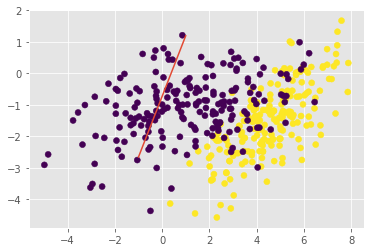

In [47]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)
cl = MySGDClassifier(5, 0.005, 100)
cl.fit(X, y)
w = cl.give_weights()

print "Weights = ", w, "\n"

a = -1
b = 1
c = -(w[0] + w[1] * a) / w[2]
d = -(w[0] + w[1] * b) / w[2]
plt.plot([a, b], [c, d])
plt.show()

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [12]:
from sklearn.datasets import make_classification

In [57]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

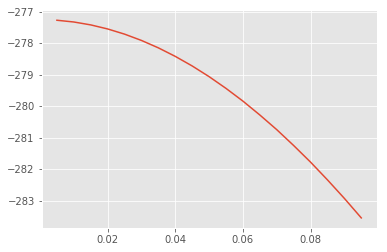

In [49]:
## Your Code Here
a = np.arange(0.005, 0.1, 0.005)
x = []
for alpha in a:
    cl = MySGDClassifier(4, alpha, 90)
    cl.fit(X, y)
    x.append(cl.give_looses())
    
plt.plot(a, x)


## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

In [68]:
## Your Code Here
C = np.logspace(3, -3, 10)
w = np.zeros((10, 11))

for i, c in enumerate(C):
    cl = MySGDClassifier(c, 0.01, 10)
    cl.fit(X, y)
    q = cl.give_weights()
    w[i] = q
    
w = w.T

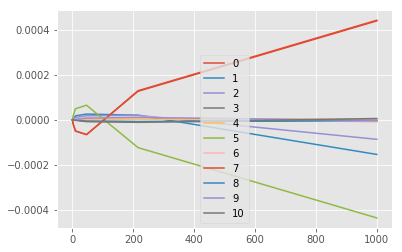

In [71]:
for j in range(11):
    plt.plot(C, w[j], label=j)
    
plt.legend()
plt.show()

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [ ]:
# Загрузка данных целиком
# df_list = []
# for chunk in range(1,5):
#     filepath = './trainingData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))
# df_data = pd.concat(df_list)

# Загрузка одной части данных
# filepath = './trainingData_tabular_chunk1.csv'
# df_data = pd.read_csv(filepath, sep=',')

In [ ]:
df_data.shape

In [ ]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [ ]:
df_data.head().T

In [ ]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [ ]:
## Youd Code Here

## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [ ]:
## Youd Code Here

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [ ]:
## Youd Code Here